<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Laplace_On_Disc/LaplaceOnDisc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.random as random
import jax.numpy as jnp
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def poisson_kernel(r, theta):
  return ((1 - jnp.power(r, 2)) / 
          (1 - 2 * r * jnp.cos(theta) + jnp.power(r, 2)))

In [3]:
'''
solve_at_point : Solves the Dirichlet problem for Laplace's equation on a 2D 
disc at polar coordinates (r, theta). Also takes the boundary condition as a
parameter.

Parameters
--------------------
g : the boundary condition as a vectorized function
k : the kernel function of the integral equation as a vectorized function
r : the radius of the polar coordinates as a single number
theta : the angle of the polar coordinates as a single number
n_samples : the number of samples of E[g(X)] where X ~ P(theta - phi)
t : the number of discrete time steps of the Metropolis-Hastings algorithm to
sample from X
key : the key to use for randomness

Returns : the solution to the Dirichlet problem for Laplace's equation on a 2D
disc at the given point with the given boundary condition

Notes
--------------------
Currently, we want to use the Poisson kernel P(theta), so set k as 
poisson_kernel(r)

P(theta) = (1 - r^2) / (1 - 2*r*cos(theta) + r^2)
'''
def solve_at_point(g, k, r, theta, n_samples, t, key):
  # generate keys
  keys = random.split(key, 2 * t + 1)

  # sample from X ~ P(theta - phi) with Metropolis-Hastings
  # create initial guess with Q(x'|x) as a uniform distribution over the domain
  current_samples = random.uniform(keys[-1], shape=(1, n_samples)) * 2 * jnp.pi
  samples = jnp.tile(current_samples, (1, 1))
  # run markov chain over time
  for i in range(0, 2*t, 2):
    # create proposed states to move to
    proposals = random.uniform(keys[i], shape=(1, n_samples)) * 2 * jnp.pi
    # compute acceptance probability
    A = (jnp.ones(n_samples) * 
         k(r, theta - proposals) / 
         k(r, theta - current_samples))
    A = jnp.minimum(1, A)
    # generate uniform r.v.
    U = random.uniform(keys[i+1], shape=(1, n_samples))
    # move or don't move states based on A and U
    new_samples = jnp.where(U <= A, proposals, current_samples)
    # add and update samples
    samples = jnp.append(samples, new_samples, axis=0)
    current_samples = new_samples

  # compute E(g(X))
  G = g(samples[int(t * 0.1):]) # 0.1 is conjectured based on plots
  E = jnp.mean(G, axis=0)
  return samples, jnp.mean(E)

In [4]:
n_samples = 1000
t = 100
r = 0.5
theta = jnp.pi / 2
key = random.PRNGKey(int(time.time()))
samples, ans = solve_at_point(jnp.sin, poisson_kernel, r, theta, n_samples, 
                              t, key)
ans

DeviceArray(0.4979559, dtype=float32)

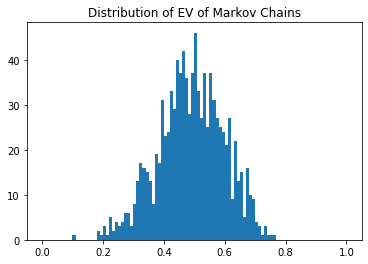

In [5]:
# plot distibution of EV of markov chains
G = jnp.sin(samples)
E = jnp.mean(G, axis=0)
plt.hist(E, jnp.arange(0, 1.01, 0.01))
plt.title("Distribution of EV of Markov Chains")
plt.show()

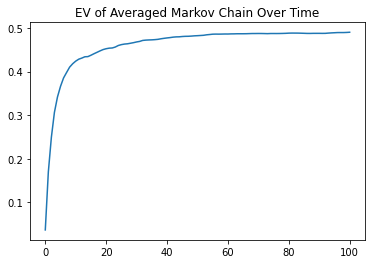

In [6]:
# plot EV of markov chains over time
E_over_time = jnp.cumsum(jnp.mean(G, axis=1)) / jnp.arange(1, t+2)
plt.plot(E_over_time)
plt.title("EV of Averaged Markov Chain Over Time")
plt.show()

In [ ]:
'''
solve_at : Solves the Dirichlet problem for Laplace's equation on a 2D disc at
given vectors of r and theta. Also takes the boundary condition as a
parameter.

Parameters
--------------------
g : the boundary condition as a vectorized function
k : the kernel function of the integral equation as a vectorized function
r : the radius of the polar coordinates as a column vector
theta : the angle of the polar coordinates as a column vector
n_samples : the number of samples of E[g(X)] where X ~ P(theta - phi)
t : the number of discrete time steps of the Metropolis-Hastings algorithm to
sample from X
key : the key to use for randomness

Returns : the solution to the Dirichlet problem for Laplace's equation on a 2D
disc at the given point with the given boundary condition

Notes
--------------------
Currently, we want to use the Poisson kernel P(theta), so set k as 
poisson_kernel(r)

P(theta) = (1 - r^2) / (1 - 2*r*cos(theta) + r^2)
'''
def solve_at(g, k, r, theta, n_samples, t, key):
  # generate keys
  keys = random.split(key, 2 * t + 1)

  # sample from X ~ P(theta - phi) with Metropolis-Hastings
  # create initial guess with Q(x'|x) as a uniform distribution over the domain
  current_samples = random.uniform(keys[-1], shape=(1, n_samples)) * 2 * jnp.pi
  current_samples = jnp.tile(current_samples, len(r))
  samples = jnp.tile(current_samples, (1, 1))
  # run markov chain over time
  for i in range(0, 2*t, 2):
    # create proposed states to move to
    proposals = random.uniform(keys[i], shape=(1, n_samples)) * 2 * jnp.pi
    # compute acceptance probability
    A = k(r, theta - proposals) / k(r, theta - current_samples)
    A = jnp.minimum(1, A)
    # generate uniform r.v.
    U = random.uniform(keys[i+1], shape=(len(r), n_samples))
    # move or don't move states based on A and U
    new_samples = jnp.where(U <= A, proposals, current_samples)
    # add and update samples
    samples = jnp.append(samples, new_samples, axis=0)
    current_samples = new_samples

  # compute E(g(X))
  G = g(samples)
  E = jnp.mean(G, axis=0)
  return samples, jnp.mean(E)

In [ ]:
n_samples = 10
t = 10
r = jnp.arange(0, 1.2, 0.2)[:, None]
theta = (jnp.ones(6) * jnp.pi / 2)[:, None]
key = random.PRNGKey(int(time.time()))
samples, ans = solve_at(jnp.sin, poisson_kernel, r, theta, n_samples, t, key)

In [ ]:
ans

DeviceArray(0.6244727, dtype=float32)